In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_truncated_normal_observation import ARTruncatedNormalObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import time

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj0 = rendered_data[0]

In [4]:
from project_ssms.momentum_utils import filter_traj_by_speed

In [5]:
f_traj = filter_traj_by_speed(traj0, q1=0.99, q2=0.99)

In [6]:
arena_xmin = 10
arena_xmax = 320

arena_ymin = -10
arena_ymax = 390

In [7]:
K = 4
D = 4
lags = 30

bounds = np.array([[arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5], 
                   [arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5]])

As = np.array([np.column_stack([np.identity(D), np.zeros((D, (lags-1) * D))]) for _ in range(K)])


In [8]:
torch.manual_seed(0)
np.random.seed(0)

tran = LinearTransformation(K=K, D=D, lags=lags, As=As)
observation = ARTruncatedNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(f_traj, dtype=torch.float64)

In [9]:
T = 36000

In [10]:
model.log_likelihood(data)

tensor(-53434212.5912, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [18]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [11]:
losses, optimizer = model.fit(data, method='adam', num_iters=5000, lr=0.005)

iter 4990 loss 693702.45: 100%|██████████| 5000/5000 [44:09<00:00,  1.80it/s]   | 0/5000 [00:00<?, ?it/s]


In [14]:
losses_1, _ = model.fit(data, optimizer=optimizer, method='adam', num_iters=2000)

iter 1990 loss 680206.66: 100%|██████████| 2000/2000 [17:50<00:00,  1.82it/s] | 0/2000 [00:00<?, ?it/s]


In [19]:
losses_2, optimizer_2 = model.fit(data, method='adam', num_iters=5000, lr=0.001)

iter 4990 loss 399907.68: 100%|██████████| 5000/5000 [42:38<00:00,  2.00it/s] | 0/5000 [00:00<?, ?it/s]


In [29]:
losses_3, optimizer_3 = model.fit(data, method='adam', num_iters=5000, lr=0.0005)

iter 4990 loss 322664.46: 100%|██████████| 5000/5000 [44:42<00:00,  1.98it/s] | 0/5000 [00:00<?, ?it/s]


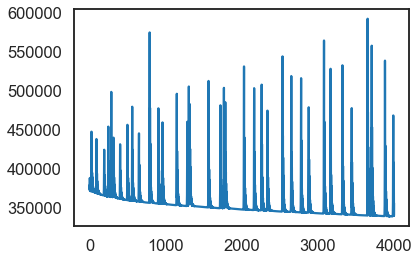

In [21]:
plt.plot(losses_2[1000:])

In [ ]:
plt.plot(losses_2[1000:])

In [22]:
z = model.most_likely_states(data)

In [23]:
x_predict_arr = k_step_prediction(model, z, data)

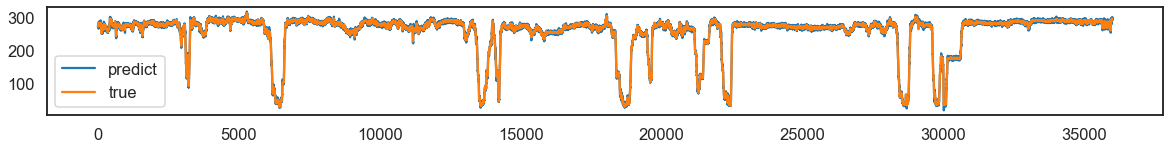

In [24]:
plt.figure(figsize=(20,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

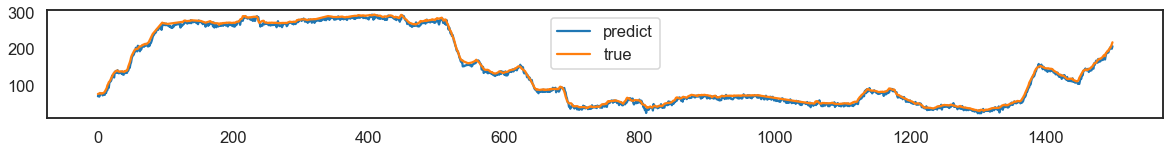

In [25]:
# zoom in
plt.figure(figsize=(20,2))
plt.plot(x_predict_arr[3500:5000,2], label='predict')
plt.plot(data[3500:5000,2].numpy(), label='true')
plt.legend()
plt.show()

([], <a list of 0 Text yticklabel objects>)

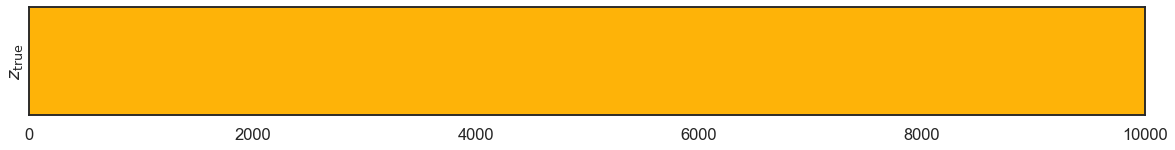

In [26]:
plt.figure(figsize=(20,2))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, 10000)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [27]:
sample_z, sample_x = model.sample(T)

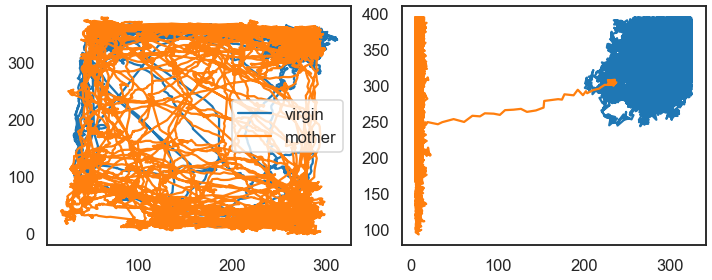

In [28]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(data[:,0].numpy(), data[:,1].numpy(), label='virgin')
plt.plot(data[:,2].numpy(), data[:,3].numpy(), label='mother')
plt.legend()

plt.subplot(1,2,2)
plt.plot(sample_x[:,0], sample_x[:,1], label='virgin')
plt.plot(sample_x[:,2], sample_x[:,3], label='mother')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,0])

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(2,4,1)
plt.hist(sample_x[:,0], bins=50, density=True);
plt.subplot(2,4,2)
plt.hist(sample_x[:,1], bins=50, density=True);
plt.subplot(2,4,3)
plt.hist(sample_x[:,2], bins=50, density=True);
plt.subplot(2,4,4)
plt.hist(sample_x[:,3], bins=50, density=True);

plt.subplot(2,4,5)
plt.hist(data[:,0].numpy(), bins=50, density=True);
plt.subplot(2,4,6)
plt.hist(data[:,1].numpy(), bins=50, density=True);
plt.subplot(2,4,7)
plt.hist(data[:,2].numpy(), bins=50, density=True);
plt.subplot(2,4,8)
plt.hist(data[:,3].numpy(), bins=50, density=True);

plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(4,1,1)
plt.plot(sample_x[:,0])
plt.plot(data[:,2].numpy())
plt.subplot(4,1,2)
plt.plot(sample_x[:,1])
plt.plot(data[:,1].numpy())
plt.subplot(4,1,3)
plt.plot(sample_x[:,2])
plt.plot(data[:,2].numpy())
plt.subplot(4,1,4)
plt.plot(sample_x[:,3])
plt.plot(data[:,3].numpy())

plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,4))

plt.subplot(2,1,1)
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, 10000)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(2,1,2)
plt.imshow(sample_z[None,:10000], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, 10000)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.tight_layout()

In [ ]:
plt.imshow(sample_z[None,:10000], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [ ]:
speed0 = np.diff(data.numpy(), axis=0)

In [ ]:
speed0_fit = np.diff(x_predict_arr, axis=0)

In [ ]:
plt.plot(speed0[1:,0], label='original')
#plt.plot(speed0_fit[1:,0], label='predict', alpha=0.4)
plt.legend()

In [ ]:
speed_sample = np.diff(sample_x, axis=0)

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.hist(speed0[:,0], bins=100);

plt.subplot(1,2,2)
plt.hist(speed_sample[:,0], bins=100);

plt.tight_layout()